<a href="https://colab.research.google.com/github/orca3/llm-model-serving/blob/main/ch06/quantization_3way_300.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install vllm==0.8.5.post1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 326.4/326.4 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.4/98.4 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.0/111.0 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 94.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.6/87.6 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 MB 28.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 115.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 118.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 90.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 61.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5

In [ ]:
!pip freeze | grep vllm

vllm==0.8.5.post1


In [ ]:
!nvidia-smi

Sat May 17 20:42:58 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L4                      Off |   00000000:00:03.0 Off |                    0 |
| N/A   37C    P8             11W /   72W |       0MiB /  23034MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
!wget https://huggingface.co/datasets/anon8231489123/ShareGPT_Vicuna_unfiltered/resolve/main/ShareGPT_V3_unfiltered_cleaned_split.json
!git clone https://github.com/vllm-project/vllm.git

--2025-05-17 20:42:58--  https://huggingface.co/datasets/anon8231489123/ShareGPT_Vicuna_unfiltered/resolve/main/ShareGPT_V3_unfiltered_cleaned_split.json
Resolving huggingface.co (huggingface.co)... 13.35.202.97, 13.35.202.34, 13.35.202.121, ...
Connecting to huggingface.co (huggingface.co)|13.35.202.97|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs.hf.co/repos/58/74/5874e8234cbcd37dd31ca486e8492d9f1370bdd04829001f53991a866851e83f/35f0e213ce091ed9b9af2a1f0755e9d39f9ccec34ab281cd4ca60d70f6479ba4?response-content-disposition=inline%3B+filename*%3DUTF-8%27%27ShareGPT_V3_unfiltered_cleaned_split.json%3B+filename%3D%22ShareGPT_V3_unfiltered_cleaned_split.json%22%3B&response-content-type=application%2Fjson&Expires=1747518178&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTc0NzUxODE3OH19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy5oZi5jby9yZXBvcy81OC83NC81ODc0ZTgyMzRjYmNkMzdkZDMxY2E0ODZlODQ5MmQ5ZjEzNzBiZGQwNDgy

In [ ]:
import torch; print(torch.__version__); print(torch.version.cuda)
import time
import vllm
import os

#vllm_dir = os.path.dirname(vllm.__file__)
benchmark_script = "vllm/benchmarks/benchmark_serving.py"

2.6.0+cu124
12.4
INFO 05-17 20:43:18 [__init__.py:239] Automatically detected platform cuda.


In [ ]:
# prompts = [
#     "Who is Lionel Messi?",
#     "How many parameters does BERT-large have?",
#     "What is a Machine Learning Engineer?",
#     "Explain the size of ChatGPT model please",
# ]

In [ ]:
hf_model_id = "Qwen/Qwen2.5-7B-Instruct" # -AWQ

In [ ]:
!nohup vllm serve {hf_model_id} \
       --disable-log-requests \
       > vllm.log 2>&1 &

In [ ]:
import time
import requests


def check_vllm_status():
  max_retries = 100  # e.g. wait up to 60 seconds (30 x 2s)
  wait_time = 10

  print("⏳ Waiting for vLLM server to become healthy...")

  for i in range(max_retries):
      try:
          r = requests.get("http://127.0.0.1:8000/health")
          if r.ok:
              print("✅ vLLM server is healthy and ready!")
              break
      except Exception as e:
          print(f"Attempt {i+1}: Not ready yet...")

      time.sleep(wait_time)
  else:
      print("❌ Timed out waiting for vLLM server to start.")
  return
check_vllm_status()

⏳ Waiting for vLLM server to become healthy...
Attempt 1: Not ready yet...
Attempt 2: Not ready yet...
Attempt 3: Not ready yet...
Attempt 4: Not ready yet...
Attempt 5: Not ready yet...
Attempt 6: Not ready yet...
Attempt 7: Not ready yet...
Attempt 8: Not ready yet...
Attempt 9: Not ready yet...
Attempt 10: Not ready yet...
Attempt 11: Not ready yet...
Attempt 12: Not ready yet...
Attempt 13: Not ready yet...
Attempt 14: Not ready yet...
Attempt 15: Not ready yet...
✅ vLLM server is healthy and ready!


In [ ]:
!tail -n 300 vllm.log

INFO 05-17 21:20:41 [__init__.py:239] Automatically detected platform cuda.
2025-05-17 21:20:42.136630: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747516842.158654   13957 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747516842.165328   13957 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
INFO 05-17 21:20:50 [api_server.py:1043] vLLM API server version 0.8.5.post1
INFO 05-17 21:20:50 [api_server.py:1044] args: Namespace(subparser='serve', model_tag='Qwen/Qwen2.5-7B-Instruct', config='', host=None, port=8000, uvicorn_log_level='info', disable_uvicorn_access_log=False, allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowe

In [ ]:
!python3 {benchmark_script} \
  --backend vllm \
  --model {hf_model_id} \
  --endpoint /v1/completions \
  --dataset-name sharegpt \
  --dataset-path /content/ShareGPT_V3_unfiltered_cleaned_split.json \
  --num-prompts 10 \
  --max-concurrency 1 \
  --save-result \
  --append-result \
  --result-filename vllm_bench.json

INFO 05-17 21:23:12 [importing.py:53] Triton module has been replaced with a placeholder.
INFO 05-17 21:23:12 [__init__.py:239] Automatically detected platform cuda.
2025-05-17 21:23:12.963145: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747516992.984817   14773 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747516992.991432   14773 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
Namespace(backend='vllm', base_url=None, host='127.0.0.1', port=8000, endpoint='/v1/completions', dataset_name='sharegpt', dataset_path='/content/ShareGPT_V3_unfiltered_cleaned_split.json', max_concurrency=1, model='Qwen/Qwen2.5-7B-Instruct', tokenizer=None, use_beam_sea

In [ ]:
!python3 {benchmark_script} \
  --backend vllm \
  --model {hf_model_id} \
  --endpoint /v1/completions \
  --dataset-name sharegpt \
  --dataset-path /content/ShareGPT_V3_unfiltered_cleaned_split.json \
  --num-prompts 10 \
  --max-concurrency 10 \
  --save-result \
  --append-result \
  --result-filename vllm_bench.json

INFO 05-17 21:26:12 [importing.py:53] Triton module has been replaced with a placeholder.
INFO 05-17 21:26:13 [__init__.py:239] Automatically detected platform cuda.
2025-05-17 21:26:13.660006: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747517173.681628   15613 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747517173.688211   15613 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
Namespace(backend='vllm', base_url=None, host='127.0.0.1', port=8000, endpoint='/v1/completions', dataset_name='sharegpt', dataset_path='/content/ShareGPT_V3_unfiltered_cleaned_split.json', max_concurrency=10, model='Qwen/Qwen2.5-7B-Instruct', tokenizer=None, use_beam_se

In [ ]:
# !python3 {benchmark_script} \
#   --backend vllm \
#   --model {hf_model_id} \
#   --endpoint /v1/completions \
#   --dataset-name sharegpt \
#   --dataset-path /content/ShareGPT_V3_unfiltered_cleaned_split.json \
#   --num-prompts 50 \
#   --max-concurrency 50 \
#   --save-result \
#   --append-result \
#   --result-filename vllm_bench.json

In [ ]:
!python3 {benchmark_script} \
  --backend vllm \
  --model {hf_model_id} \
  --endpoint /v1/completions \
  --dataset-name sharegpt \
  --dataset-path /content/ShareGPT_V3_unfiltered_cleaned_split.json \
  --num-prompts 100 \
  --max-concurrency 100 \
  --save-result \
  --append-result \
  --result-filename vllm_bench.json

INFO 05-17 21:27:24 [importing.py:53] Triton module has been replaced with a placeholder.
INFO 05-17 21:27:24 [__init__.py:239] Automatically detected platform cuda.
2025-05-17 21:27:24.945847: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747517244.967824   15967 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747517244.974429   15967 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
Namespace(backend='vllm', base_url=None, host='127.0.0.1', port=8000, endpoint='/v1/completions', dataset_name='sharegpt', dataset_path='/content/ShareGPT_V3_unfiltered_cleaned_split.json', max_concurrency=100, model='Qwen/Qwen2.5-7B-Instruct', tokenizer=None, use_beam_s

In [ ]:
  !python3 {benchmark_script} \
  --backend vllm \
  --model {hf_model_id} \
  --endpoint /v1/completions \
  --dataset-name sharegpt \
  --dataset-path /content/ShareGPT_V3_unfiltered_cleaned_split.json \
  --num-prompts 300 \
  --max-concurrency 300 \
  --save-result \
  --append-result \
  --result-filename vllm_bench.json

INFO 05-17 21:28:46 [importing.py:53] Triton module has been replaced with a placeholder.
INFO 05-17 21:28:47 [__init__.py:239] Automatically detected platform cuda.
2025-05-17 21:28:47.573535: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747517327.594827   16369 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747517327.601308   16369 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
Namespace(backend='vllm', base_url=None, host='127.0.0.1', port=8000, endpoint='/v1/completions', dataset_name='sharegpt', dataset_path='/content/ShareGPT_V3_unfiltered_cleaned_split.json', max_concurrency=300, model='Qwen/Qwen2.5-7B-Instruct', tokenizer=None, use_beam_s

In [ ]:
!pkill -f "vllm serve" && sleep 10

^C


In [ ]:
!ps aux | grep "vllm serve" | grep -v grep

root       13957  4.7  2.7 13040164 1499736 ?    Sl   21:20   0:27 /usr/bin/python3 /usr/local/bin/vllm serve Qwen/Qwen2.5-7B-Instruct --disable-log-requests


In [ ]:
hf_model_id = "Qwen/Qwen2.5-7B-Instruct-GPTQ-Int4" # you can try AWQ W4A16 as well

In [ ]:
!nohup vllm serve {hf_model_id} \
       --disable-log-requests \
       > vllm.log 2>&1 &

In [ ]:
check_vllm_status()

⏳ Waiting for vLLM server to become healthy...
Attempt 1: Not ready yet...
Attempt 2: Not ready yet...
Attempt 3: Not ready yet...
Attempt 4: Not ready yet...
Attempt 5: Not ready yet...
Attempt 6: Not ready yet...
Attempt 7: Not ready yet...
Attempt 8: Not ready yet...
Attempt 9: Not ready yet...
Attempt 10: Not ready yet...
Attempt 11: Not ready yet...
Attempt 12: Not ready yet...
Attempt 13: Not ready yet...
✅ vLLM server is healthy and ready!


In [ ]:
!python3 {benchmark_script} \
  --backend vllm \
  --model {hf_model_id} \
  --endpoint /v1/completions \
  --dataset-name sharegpt \
  --dataset-path /content/ShareGPT_V3_unfiltered_cleaned_split.json \
  --num-prompts 10 \
  --max-concurrency 1 \
  --save-result \
  --append-result \
  --result-filename vllm_bench.json

!python3 {benchmark_script} \
--backend vllm \
--model {hf_model_id} \
--endpoint /v1/completions \
--dataset-name sharegpt \
--dataset-path /content/ShareGPT_V3_unfiltered_cleaned_split.json \
--num-prompts 10 \
--max-concurrency 10 \
--save-result \
--append-result \
--result-filename vllm_bench.json

# !python3 {benchmark_script} \
# --backend vllm \
# --model {hf_model_id} \
# --endpoint /v1/completions \
# --dataset-name sharegpt \
# --dataset-path /content/ShareGPT_V3_unfiltered_cleaned_split.json \
# --num-prompts 50 \
# --max-concurrency 50 \
# --save-result \
# --append-result \
# --result-filename vllm_bench.json

!python3 {benchmark_script} \
  --backend vllm \
  --model {hf_model_id} \
  --endpoint /v1/completions \
  --dataset-name sharegpt \
  --dataset-path /content/ShareGPT_V3_unfiltered_cleaned_split.json \
  --num-prompts 100 \
  --max-concurrency 100 \
  --save-result \
  --append-result \
  --result-filename vllm_bench.json


!python3 {benchmark_script} \
--backend vllm \
--model {hf_model_id} \
--endpoint /v1/completions \
--dataset-name sharegpt \
--dataset-path /content/ShareGPT_V3_unfiltered_cleaned_split.json \
--num-prompts 300 \
--max-concurrency 300 \
--save-result \
--append-result \
--result-filename vllm_bench.json

INFO 05-17 21:34:06 [importing.py:53] Triton module has been replaced with a placeholder.
INFO 05-17 21:34:06 [__init__.py:239] Automatically detected platform cuda.
2025-05-17 21:34:07.114615: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747517647.138287   17942 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747517647.145064   17942 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
Namespace(backend='vllm', base_url=None, host='127.0.0.1', port=8000, endpoint='/v1/completions', dataset_name='sharegpt', dataset_path='/content/ShareGPT_V3_unfiltered_cleaned_split.json', max_concurrency=1, model='Qwen/Qwen2.5-7B-Instruct-GPTQ-Int4', tokenizer=None, us

In [ ]:
!pkill -f "vllm serve" && sleep 10

^C


In [ ]:
!ps aux | grep "vllm serve" | grep -v grep

root       16858  5.9  2.6 13043392 1492388 ?    Sl   21:30   0:26 /usr/bin/python3 /usr/local/bin/vllm serve Qwen/Qwen2.5-7B-Instruct-GPTQ-Int4 --disable-log-requests


In [ ]:
hf_model_id = "RedHatAI/Qwen2.5-7B-Instruct-FP8-dynamic"

In [ ]:
!nohup vllm serve {hf_model_id} \
       --disable-log-requests \
       > vllm.log 2>&1 &

In [ ]:
check_vllm_status()

⏳ Waiting for vLLM server to become healthy...
Attempt 1: Not ready yet...
Attempt 2: Not ready yet...
Attempt 3: Not ready yet...
Attempt 4: Not ready yet...
Attempt 5: Not ready yet...
Attempt 6: Not ready yet...
Attempt 7: Not ready yet...
Attempt 8: Not ready yet...
Attempt 9: Not ready yet...
Attempt 10: Not ready yet...
Attempt 11: Not ready yet...
Attempt 12: Not ready yet...
Attempt 13: Not ready yet...
Attempt 14: Not ready yet...
✅ vLLM server is healthy and ready!


In [ ]:
!python3 {benchmark_script} \
  --backend vllm \
  --model {hf_model_id} \
  --endpoint /v1/completions \
  --dataset-name sharegpt \
  --dataset-path /content/ShareGPT_V3_unfiltered_cleaned_split.json \
  --num-prompts 10 \
  --max-concurrency 1 \
  --save-result \
  --append-result \
  --result-filename vllm_bench.json

!python3 {benchmark_script} \
--backend vllm \
--model {hf_model_id} \
--endpoint /v1/completions \
--dataset-name sharegpt \
--dataset-path /content/ShareGPT_V3_unfiltered_cleaned_split.json \
--num-prompts 10 \
--max-concurrency 10 \
--save-result \
--append-result \
--result-filename vllm_bench.json

# !python3 {benchmark_script} \
# --backend vllm \
# --model {hf_model_id} \
# --endpoint /v1/completions \
# --dataset-name sharegpt \
# --dataset-path /content/ShareGPT_V3_unfiltered_cleaned_split.json \
# --num-prompts 50 \
# --max-concurrency 50 \
# --save-result \
# --append-result \
# --result-filename vllm_bench.json

!python3 {benchmark_script} \
  --backend vllm \
  --model {hf_model_id} \
  --endpoint /v1/completions \
  --dataset-name sharegpt \
  --dataset-path /content/ShareGPT_V3_unfiltered_cleaned_split.json \
  --num-prompts 100 \
  --max-concurrency 100 \
  --save-result \
  --append-result \
  --result-filename vllm_bench.json

!python3 {benchmark_script} \
--backend vllm \
--model {hf_model_id} \
--endpoint /v1/completions \
--dataset-name sharegpt \
--dataset-path /content/ShareGPT_V3_unfiltered_cleaned_split.json \
--num-prompts 300 \
--max-concurrency 300 \
--save-result \
--append-result \
--result-filename vllm_bench.json

INFO 05-17 21:40:23 [importing.py:53] Triton module has been replaced with a placeholder.
INFO 05-17 21:40:23 [__init__.py:239] Automatically detected platform cuda.
2025-05-17 21:40:23.984921: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747518024.006858   19960 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747518024.013458   19960 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
Namespace(backend='vllm', base_url=None, host='127.0.0.1', port=8000, endpoint='/v1/completions', dataset_name='sharegpt', dataset_path='/content/ShareGPT_V3_unfiltered_cleaned_split.json', max_concurrency=1, model='RedHatAI/Qwen2.5-7B-Instruct-FP8-dynamic', tokenizer=No

In [ ]:
import matplotlib.pyplot as plt
import json

# Load the JSON lines from a local json saved containing benchmark results
with open("vllm_bench.json", "r") as f:
    data = [json.loads(line) for line in f if line.strip()]



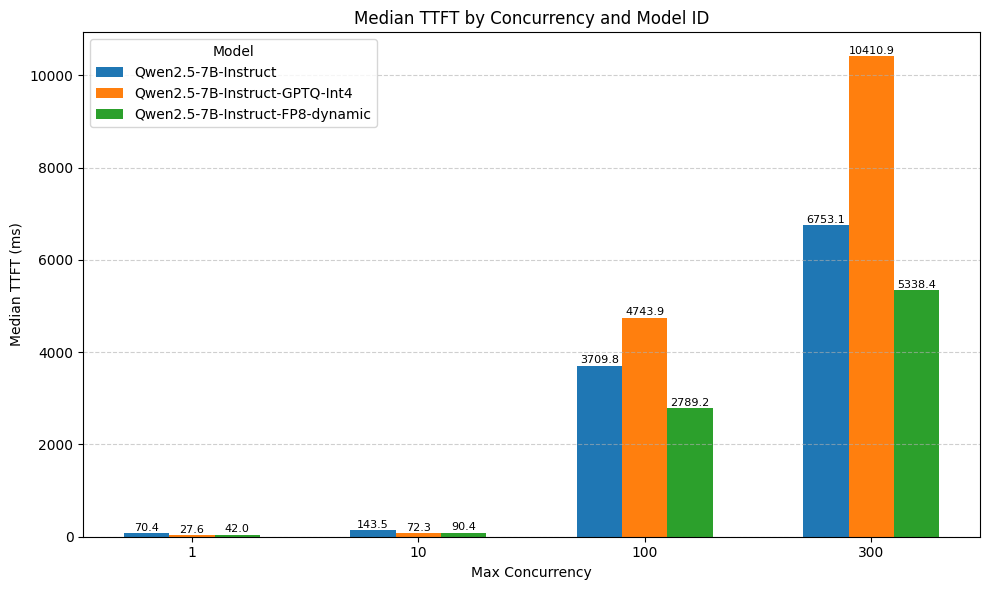

In [ ]:
import matplotlib.pyplot as plt
import json
import numpy as np

# Parse raw data
#raw_data = """<...your data here...>"""  # keep the full string as before
#data = [json.loads(line) for line in raw_data.strip().split('\n')]

# Organize by rate (max_concurrency)
grouped = {}
for entry in data:
    rate = entry["max_concurrency"]
    model = entry["model_id"]
    ttft = entry["median_ttft_ms"]
    if rate not in grouped:
        grouped[rate] = {}
    grouped[rate][model] = ttft

# Sort the group keys (rates) for consistent display
sorted_rates = sorted(grouped.keys())

# Unique models across all groups
all_models = sorted(set(model for group in grouped.values() for model in group))

# Prepare bar positions and heights
bar_width = 0.2
x = np.arange(len(sorted_rates))
offsets = np.linspace(-bar_width*(len(all_models)-1)/2, bar_width*(len(all_models)-1)/2, len(all_models))

plt.figure(figsize=(10, 6))

for i, model in enumerate(all_models):
    ttft_values = [grouped[rate].get(model, 0) for rate in sorted_rates]
    bar_positions = x + offsets[i]
    bars = plt.bar(bar_positions, ttft_values, bar_width, label=model.split("/")[-1])

    # Add text labels above each bar
    for pos, val in zip(bar_positions, ttft_values):
        if val > 0:
            plt.text(pos, val + 10, f"{val:.1f}", ha='center', va='bottom', fontsize=8)


plt.xlabel("Max Concurrency")
plt.ylabel("Median TTFT (ms)")
plt.title("Median TTFT by Concurrency and Model ID")
plt.xticks(x, sorted_rates)
plt.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.legend(title="Model")
plt.tight_layout()
plt.show()


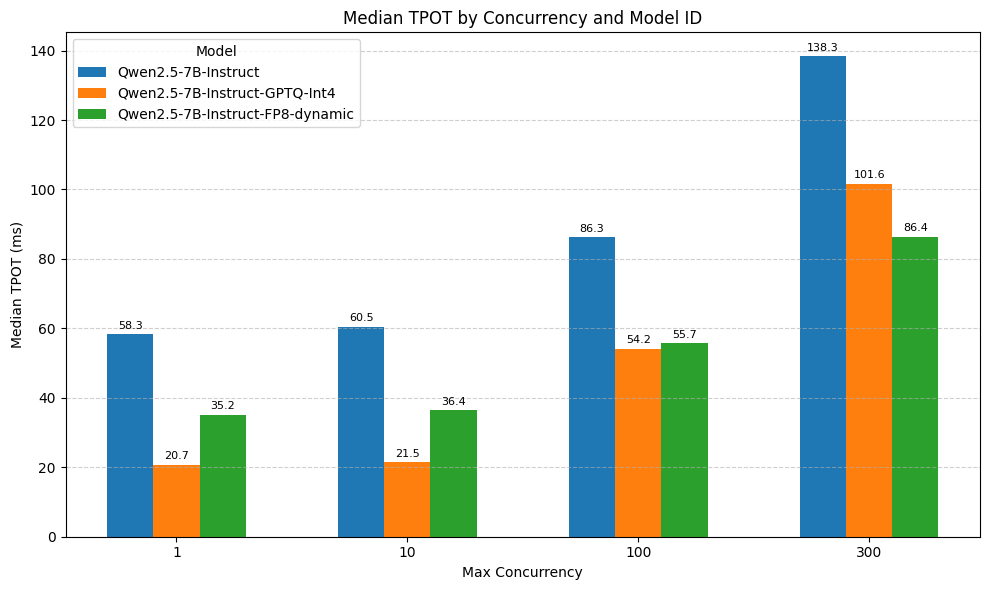

In [ ]:
import matplotlib.pyplot as plt
import json
import numpy as np

# Parse raw data
#raw_data = """<...your data here...>"""  # keep the full string as before
#data = [json.loads(line) for line in raw_data.strip().split('\n')]

# Organize by rate (max_concurrency)
grouped = {}
for entry in data:
    rate = entry["max_concurrency"]
    model = entry["model_id"]
    ttft = entry["median_tpot_ms"]
    if rate not in grouped:
        grouped[rate] = {}
    grouped[rate][model] = ttft

# Sort the group keys (rates) for consistent display
sorted_rates = sorted(grouped.keys())

# Unique models across all groups
all_models = sorted(set(model for group in grouped.values() for model in group))

# Prepare bar positions and heights
bar_width = 0.2
x = np.arange(len(sorted_rates))
offsets = np.linspace(-bar_width*(len(all_models)-1)/2, bar_width*(len(all_models)-1)/2, len(all_models))

plt.figure(figsize=(10, 6))

for i, model in enumerate(all_models):
    ttft_values = [grouped[rate].get(model, 0) for rate in sorted_rates]
    bar_positions = x + offsets[i]
    bars = plt.bar(bar_positions, ttft_values, bar_width, label=model.split("/")[-1])

    # Add text labels above each bar
    for pos, val in zip(bar_positions, ttft_values):
        if val > 0:
            plt.text(pos, val + 1, f"{val:.1f}", ha='center', va='bottom', fontsize=8)


plt.xlabel("Max Concurrency")
plt.ylabel("Median TPOT (ms)")
plt.title("Median TPOT by Concurrency and Model ID")
plt.xticks(x, sorted_rates)
plt.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.legend(title="Model")
plt.tight_layout()
plt.show()


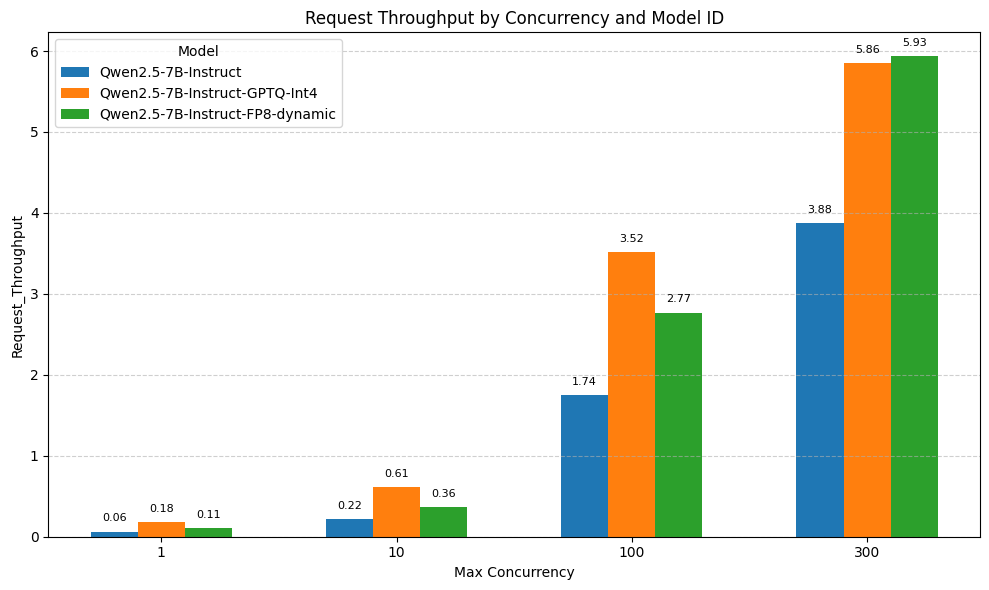

In [ ]:
import matplotlib.pyplot as plt
import json
import numpy as np

# Parse raw data
#raw_data = """<...your data here...>"""  # keep the full string as before
#data = [json.loads(line) for line in raw_data.strip().split('\n')]

# Organize by rate (max_concurrency)
grouped = {}
for entry in data:
    rate = entry["max_concurrency"]
    model = entry["model_id"]
    ttft = entry["request_throughput"]
    if rate not in grouped:
        grouped[rate] = {}
    grouped[rate][model] = ttft

# Sort the group keys (rates) for consistent display
sorted_rates = sorted(grouped.keys())

# Unique models across all groups
all_models = sorted(set(model for group in grouped.values() for model in group))

# Prepare bar positions and heights
bar_width = 0.2
x = np.arange(len(sorted_rates))
offsets = np.linspace(-bar_width*(len(all_models)-1)/2, bar_width*(len(all_models)-1)/2, len(all_models))

plt.figure(figsize=(10, 6))

for i, model in enumerate(all_models):
    ttft_values = [grouped[rate].get(model, 0) for rate in sorted_rates]
    bar_positions = x + offsets[i]
    bars = plt.bar(bar_positions, ttft_values, bar_width, label=model.split("/")[-1])

    # Add text labels above each bar
    for pos, val in zip(bar_positions, ttft_values):
        if val > 0:
            plt.text(pos, val + 0.1, f"{val:.2f}", ha='center', va='bottom', fontsize=8)


plt.xlabel("Max Concurrency")
plt.ylabel("Request_Throughput")
plt.title("Request Throughput by Concurrency and Model ID")
plt.xticks(x, sorted_rates)
plt.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.legend(title="Model")
plt.tight_layout()
plt.show()
